In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import math
#import seaborn as sns
from sklearn.cluster import KMeans

def custom_grouping(index):
    return index // 1000

names_bw=['time', 'bw', 'op1', 'size', 'op2' ]
names_latency=['time', 'latency', 'op2', 'write_size', 'op3']

In [2]:
# Define a custom grouping function
  
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/4KB/90-10-LBA/90Util/15Zones.WakeOne/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = round(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = df['submission_time'] + df['duration']

In [13]:
# Step 3: Determine the start and end time of the entire test
start_time = df['submission_time'].min()
end_time = math.ceil(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 4096
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

/tmp/ipykernel_562059/515047452.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3764.91350626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


917503


In [14]:
#assert math.ceil(data_written_ms.data_written_bytes.sum()) == len(df)*4096
print(math.ceil(data_written_ms.data_written_bytes.sum()))
print(len(df) * 4096)

3758096385
3758096384


In [15]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['payload'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped.describe())
print(df_grouped.info())

              index  data_written_bytes  cumulative_gb       payload
count  1.365574e+06        1.365574e+06   1.365574e+06  1.365574e+06
mean   6.827865e+05        2.752027e+03   3.015001e+00  2.624537e-03
std    3.942074e+05        1.105883e+05   2.112334e-01  1.054652e-01
min    0.000000e+00        0.000000e+00   5.746193e-03  0.000000e+00
25%    3.413932e+05        1.359172e+02   2.792359e+00  1.296208e-04
50%    6.827865e+05        1.487996e+02   3.023616e+00  1.419064e-04
75%    1.024180e+06        1.545260e+02   3.261831e+00  1.473675e-04
max    1.365573e+06        1.236199e+07   3.500000e+00  1.178931e+01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365574 entries, 0 to 1365573
Data columns (total 4 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   index               1365574 non-null  int64  
 1   data_written_bytes  1365574 non-null  float64
 2   cumulative_gb       1365574 non-null  float64
 3   payload

Average1: 271
Average2: 4389094


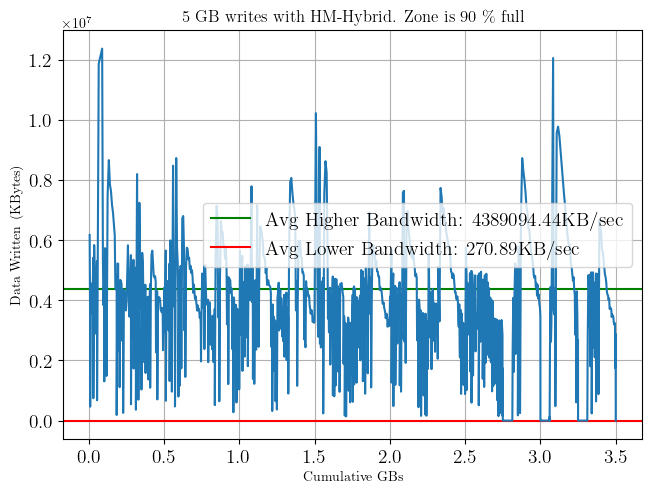

In [16]:
data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'KB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'KB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written (KBytes)')
plt.grid(True)  # Optionally, add grid lines
plt.title("5 GB writes with HM-Hybrid. Zone is 90 \% full")
    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/4K_90Util_HMHybrid_CGBW.png', bbox_inches='tight')
plt.show()